In [2]:
from nilearn import datasets, maskers, plotting,image,connectome
import matplotlib.pyplot as plt
import numpy as np
from bids.layout import BIDSLayout
import networkx as nx

In [3]:
#base directory
fmriprep_dir='../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)
len(layout.get_subjects())
fmri_files=layout.get(datatype='func',extension='.nii.gz',return_type="file")
print(len(fmri_files))


71


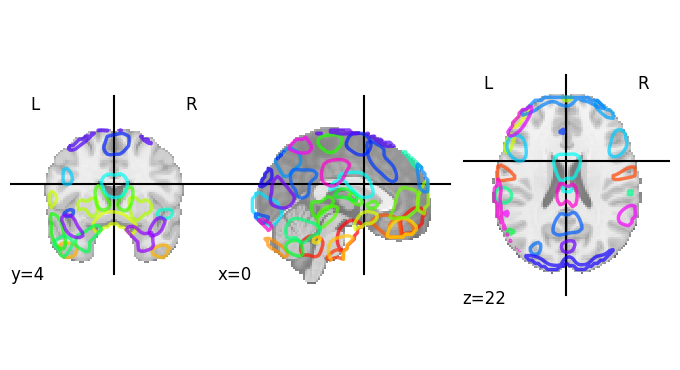

In [4]:
allen_atlas=datasets.fetch_atlas_allen_2011()

plotting.plot_prob_atlas(allen_atlas.maps)

In [5]:
print(allen_atlas.networks)

[['Basal Ganglia'], ['Auditory'], ['Sensorimotor', 'Sensorimotor', 'Sensorimotor', 'Sensorimotor', 'Sensorimotor', 'Sensorimotor'], ['Visual', 'Visual', 'Visual', 'Visual', 'Visual', 'Visual'], ['Default-Mode', 'Default-Mode', 'Default-Mode', 'Default-Mode'], ['Attentional', 'Attentional', 'Attentional', 'Attentional', 'Attentional', 'Attentional'], ['Frontal', 'Frontal', 'Frontal', 'Frontal']]


In [6]:
masker=maskers.NiftiMapsMasker(maps_img=allen_atlas.maps, standardize=True, verbose=1,
                         memory="nilearn_cache", memory_level=2)

In [7]:
correlation_measure = connectome.ConnectivityMeasure(kind='correlation',standardize='zscore_sample')

In [8]:
#base directory
def create_fc_matrices():
    fmriprep_dir='../Full-Dataset'
    layout=BIDSLayout(fmriprep_dir)
    msdl_atlas=datasets.fetch_atlas_msdl()

    print(f'Number of labels in the atlas: {len(msdl_atlas.labels)}\n')

    fmri_files=layout.get(datatype='func',extension='.nii.gz',return_type="file")

    print(f'Number of Subjects in the Dataset:{len(fmri_files)}\n')

    masker=input_data.NiftiMapsMasker(maps_img=msdl_atlas.maps, standardize='zscore_sample', verbose=0)
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation',standardize='zscore_sample')

    subject_corr=[]

    for file in fmri_files:
        # print(file)
        fmri_data = image.load_img(file)
        time_series = masker.fit_transform(fmri_data)
        corr_matrix=correlation_measure.fit_transform([time_series])[0]
        # corr_matrix = np.corrcoef(time_series, rowvar=False)
        np.fill_diagonal(corr_matrix, 0)
        subject_corr.append(corr_matrix)
        print(f'Subjects left to Compute {len(fmri_files)-len(subject_corr)}')
    
    return subject_corr

In [102]:
fc_matrices=create_fc_matrices()

Number of labels in the atlas: 39

Number of Subjects in the Dataset:71

Subjects left to Compute 70
Subjects left to Compute 69
Subjects left to Compute 68
Subjects left to Compute 67
Subjects left to Compute 66
Subjects left to Compute 65
Subjects left to Compute 64
Subjects left to Compute 63
Subjects left to Compute 62
Subjects left to Compute 61
Subjects left to Compute 60
Subjects left to Compute 59
Subjects left to Compute 58
Subjects left to Compute 57
Subjects left to Compute 56
Subjects left to Compute 55
Subjects left to Compute 54
Subjects left to Compute 53
Subjects left to Compute 52
Subjects left to Compute 51
Subjects left to Compute 50
Subjects left to Compute 49
Subjects left to Compute 48
Subjects left to Compute 47
Subjects left to Compute 46
Subjects left to Compute 45
Subjects left to Compute 44
Subjects left to Compute 43
Subjects left to Compute 42
Subjects left to Compute 41
Subjects left to Compute 40
Subjects left to Compute 39
Subjects left to Compute 38
Sub

In [130]:
np.save('fc_matrices',fc_matrices)

In [9]:
fc_matrices=np.load('fc_matrices.npy')

In [10]:
# Path to MSDL atlas
msdl_atlas = datasets.fetch_atlas_msdl()
msdl_labels = msdl_atlas.labels
msdl_coords = msdl_atlas.region_coords

In [11]:
len(fc_matrices)

71

In [19]:
def create_knn_graph(fc_matrices, k):
    # Calculate group FC matrix by averaging individual FC matrices
    group_fc_matrix_strength = np.mean(fc_matrices, axis=0)
    print(f'Shape of mean fc corr (strength) {group_fc_matrix_strength.shape}')
    print(group_fc_matrix_strength)

    # Create k-NN graph
    G = nx.Graph()
    num_nodes = group_fc_matrix_strength.shape[0]

    for i in range(num_nodes):
        # Find the indices of the top k edges in terms of connectivity strength
        top_k_indices = np.argsort(group_fc_matrix_strength[i, :])[-k:]

        # Add edges to the graph
        for j in top_k_indices:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j, weight=group_fc_matrix_strength[i, j])
    return G, group_fc_matrix_strength

Shape of mean fc corr (strength) (39, 39)
[[ 0.          0.5045949   0.35592244 ... -0.00235136  0.62424422
   0.40667993]
 [ 0.5045949   0.          0.38673946 ...  0.1580873   0.32050688
   0.49068674]
 [ 0.35592244  0.38673946  0.         ...  0.20193725  0.18426252
   0.15711512]
 ...
 [-0.00235136  0.1580873   0.20193725 ...  0.         -0.10924544
   0.02615905]
 [ 0.62424422  0.32050688  0.18426252 ... -0.10924544  0.
   0.50821191]
 [ 0.40667993  0.49068674  0.15711512 ...  0.02615905  0.50821191
   0.        ]]


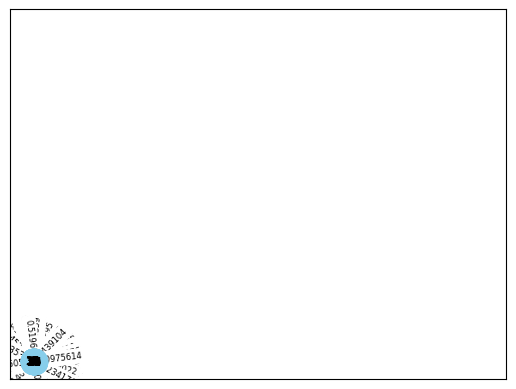

In [22]:
# Create the graph
k=5
G, group_fc_matrix_strength = create_knn_graph(fc_matrices, k)
# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [25]:
print(len(pos))

39


In [28]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
labels = list(G.nodes)

In [29]:
len(labels)

39

In [30]:
print(adjacency_matrix.shape)

(39, 39)


In [31]:
print(msdl_labels)

['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS']


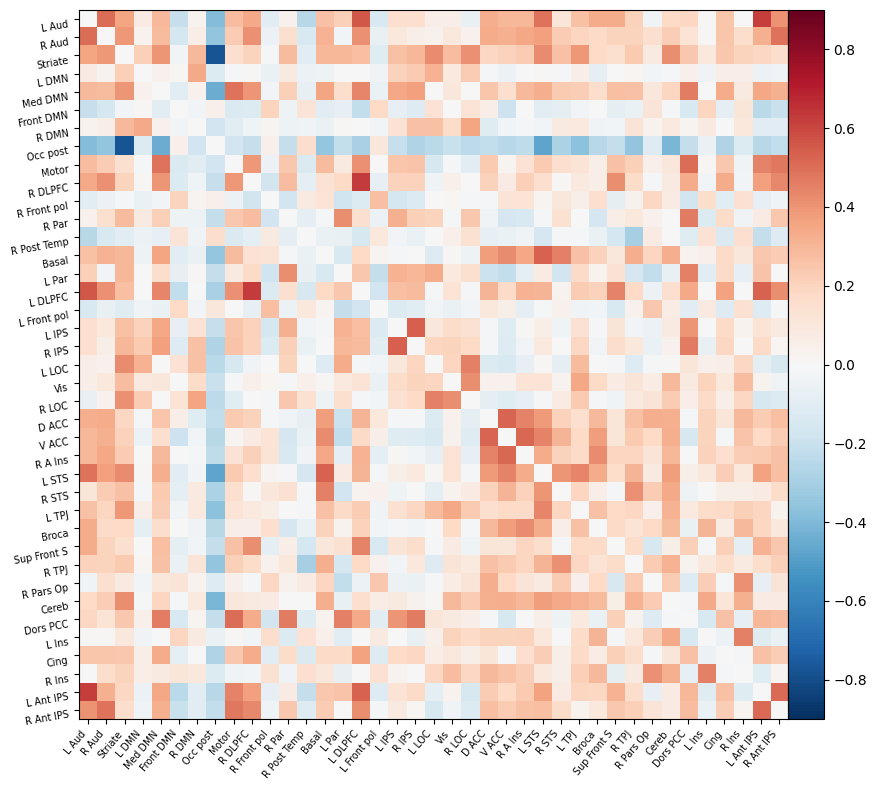

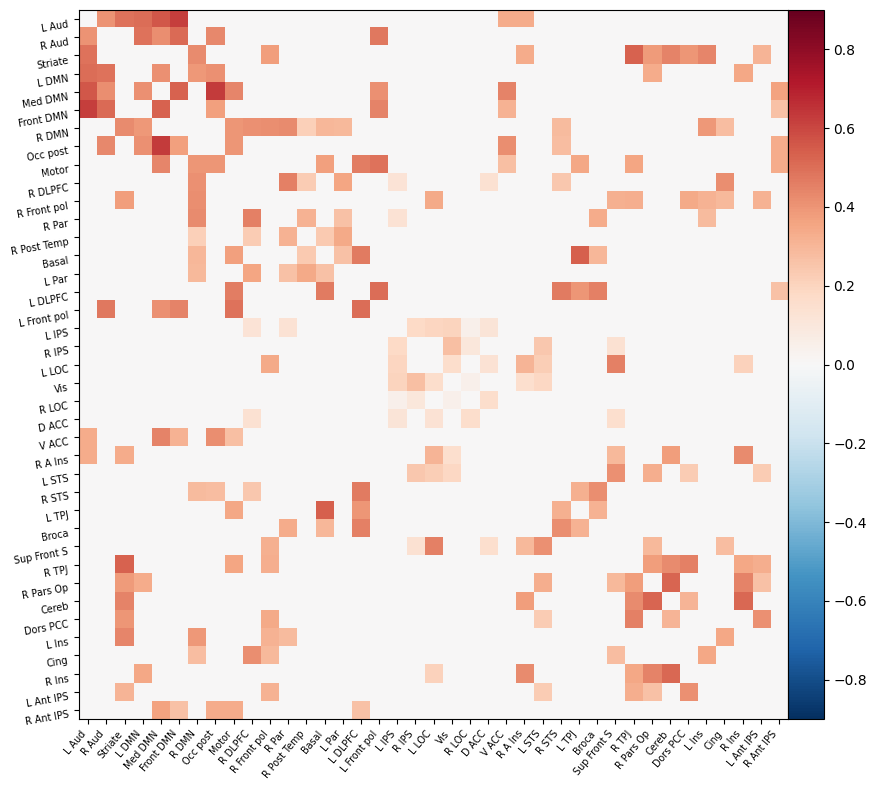

In [34]:
plotting.plot_matrix(group_fc_matrix_strength, figure=(10, 8), labels=msdl_labels,
                     vmax=0.9, vmin=-0.9)
plotting.plot_matrix(adjacency_matrix, figure=(10, 8), labels=msdl_labels,
                     vmax=0.9, vmin=-0.9)

In [136]:
print(msdl_coords)

[[-53.28, -8.88, 32.36], [53.47, -6.49, 27.52], [1.18, -74.54, 10.79], [-45.8, -64.78, 31.84], [-0.2, -55.21, 29.87], [-0.15, 51.42, 7.58], [51.66, -59.34, 28.88], [0.41, -91.05, 1.58], [-1.48, -27.93, 61.5], [40.1, 20.96, 44.72], [37.83, 55.49, 1.22], [47.53, -52.42, 43.06], [62.53, -32.99, -9.14], [-0.91, -2.75, 6.15], [-41.66, -59.04, 44.61], [-39.04, 19.28, 43.27], [-40.08, 50.65, 0.81], [-29.39, -59.43, 44.2], [31.6, -58.09, 45.69], [-30.54, -85.14, 9.1], [-24.29, -74.28, -11.74], [33.4, -77.96, 4.31], [-28.17, 46.32, 21.56], [-0.45, 34.06, 20.73], [28.38, 47.72, 22.13], [-52.12, -17.92, 13.28], [52.61, -13.65, 12.11], [-55.52, -43.77, 10.08], [-48.66, 25.11, 5.7], [-3.39, 17.19, 63.52], [54.42, -29.5, -2.72], [52.38, 29.39, 2.93], [1.05, -58.49, -23.91], [-1.44, -59.12, 55.25], [-41.33, 13.63, 2.7], [1.05, 9.2, 46.43], [43.01, 14.3, 2.79], [-47.85, -32.07, 41.9], [48.36, -29.04, 43.13]]


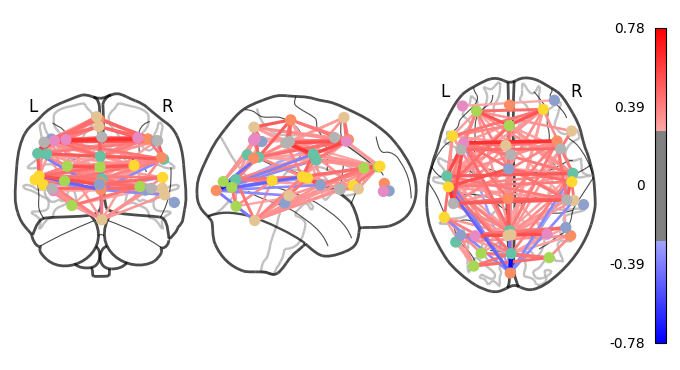

In [140]:
plotting.plot_connectome(mean_corr_matrix, msdl_coords, edge_threshold="80%", colorbar=True)